In [1]:
!pip install GEOparse

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install gseapy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# data loading and preprocessing
print("COVID-19 mRNA vaccine gene analysis")

# Load expression data
print("\n Loading expression data")
df = pd.read_csv("GSE247401_norm_counts_TPM_GRCh38.p13_NCBI.tsv.gz",
                 sep="\t", index_col=0)
print(f"Expression matrix shape: {df.shape}")
print(f"Genes: {df.shape[0]}, Samples: {df.shape[1]}")

# Load gene annotation
print("\n Loading gene annotations")
annot = pd.read_csv("Human.GRCh38.p13.annot.tsv.gz", sep="\t")
annot = annot[['GeneID', 'Symbol', 'Description', 'GeneType']]
print(f"Annotations loaded: {len(annot)} genes")

# Retrieve metadata from GEO
print("\n Retrieving metadata from GEO")
import GEOparse
gse = GEOparse.get_GEO("GSE247401", destdir="./")

def get_field(ch_list, keywords):
    #Return first matching characteristic value containing any keyword
    for ch in ch_list:
        low = ch.lower()
        for kw in keywords:
            if kw in low:
                parts = ch.split(":")
                return parts[-1].strip()
    return None

meta = []
print("look at data of first 5 samples:")
for i, (gsm_name, gsm) in enumerate(gse.gsms.items()):
    if i >= 5:
        break
    print(gsm_name, gsm.metadata.get('characteristics_ch1', []))

for gsm_name, gsm in gse.gsms.items():
    ch = gsm.metadata.get('characteristics_ch1', [])
    vacc = get_field(ch, ["vaccination", "dose", "round", "v2", "v3"])
    time = get_field(ch, ["pre", "24h", "post", "time"])
    subj = get_field(ch, ["subject", "donor", "patient", "id"])
    meta.append({
        "Sample": gsm_name,
        "Vaccination": vacc,
        "Timepoint": time,
        "Subject": subj
    })

metadata_df = pd.DataFrame(meta).set_index("Sample")
metadata_df["Condition"] = metadata_df["Vaccination"].astype(str) + "_" + metadata_df["Timepoint"].astype(str)

print("\nSample distribution:")
print(metadata_df.groupby(["Vaccination", "Timepoint"]).size())

# quality control and initial exploratory analysis
print("\n Performing quality control")

min_samples = int(0.25 * df.shape[1])
df_filtered = df[(df > 1).sum(axis=1) >= min_samples]
print(f"Genes after filtering: {df_filtered.shape[0]} (removed {df.shape[0] - df_filtered.shape[0]})")

df_log = np.log2(df_filtered + 1)


# PCA
print("\n Running PCA analysis")
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_log.T)

pca = PCA(n_components=4)
pca_result = pca.fit_transform(df_scaled)

pca_df = pd.DataFrame(pca_result[:, :4],
                      columns=['PC1', 'PC2', 'PC3', 'PC4'],
                      index=df_log.columns)
pca_df = pca_df.merge(metadata_df, left_index=True, right_index=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for timepoint in ['Pre', '24h']:
    mask = pca_df['Timepoint'] == timepoint
    axes[0].scatter(pca_df.loc[mask, 'PC1'],
                   pca_df.loc[mask, 'PC2'],
                   label=timepoint, s=100, alpha=0.7)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('PCA: Pre vs 24h Post-Vaccination')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for vac in metadata_df['Vaccination'].unique():
    mask = pca_df['Vaccination'] == vac
    axes[1].scatter(pca_df.loc[mask, 'PC1'],
                   pca_df.loc[mask, 'PC2'],
                   label=vac, s=100, alpha=0.7,
                   marker='o' if vac == metadata_df['Vaccination'].unique()[0] else '^')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('PCA: V2 vs V3')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: pca_analysis.png")
plt.close()

#Restrict metadata to samples found in the expression matrix
common_samples = metadata_df.index.intersection(df_log.columns)

print("Samples in both metadata + expression:", len(common_samples))

metadata_df = metadata_df.loc[common_samples]
df_log = df_log[common_samples]

#Verify final condition counts
print(metadata_df["Condition"].value_counts())

print("Aim 1: differential expression analysis")

from statsmodels.stats.multitest import multipletests

def perform_paired_de(expr_df, meta_df, cond_pre, cond_post, min_n=2):
    sub_pre = meta_df[meta_df["Condition"] == cond_pre]
    sub_post = meta_df[meta_df["Condition"] == cond_post]

    common_subjects = set(sub_pre["Subject"]) & set(sub_post["Subject"])
    if len(common_subjects) < min_n:
        print(f"Not enough paired samples for {cond_pre} vs {cond_post}, skipping.")
        return None

    pre_samps = sub_pre[sub_pre["Subject"].isin(common_subjects)].sort_values("Subject").index.tolist()
    post_samps = sub_post[sub_post["Subject"].isin(common_subjects)].sort_values("Subject").index.tolist()

    results = []
    for gene in expr_df.index:
        pre_vals = expr_df.loc[gene, pre_samps].values
        post_vals = expr_df.loc[gene, post_samps].values
        t_stat, p_val = stats.ttest_rel(post_vals, pre_vals, nan_policy='omit')
        results.append({
            "GeneID": gene,
            "log2FC": post_vals.mean() - pre_vals.mean(),
            "pvalue": p_val
        })

    res = pd.DataFrame(results).dropna(subset=["pvalue"])
    res["padj"] = multipletests(res["pvalue"], method="fdr_bh")[1]
    res["significant"] = (res["padj"] < 0.05) & (abs(res["log2FC"]) > 0.5)
    return res.sort_values("padj")

print("\nRunning Differential Expression Analysis")

de_v2 = perform_paired_de(df_log, metadata_df, "V2_Pre", "V2_24h")
de_v3 = perform_paired_de(df_log, metadata_df, "V3_Pre", "V3_24h")
de_v2_vs_v3 = perform_paired_de(df_log, metadata_df, "V2_24h", "V3_24h")

for name, df_de in [("V2", de_v2), ("V3", de_v3), ("V2_vs_V3", de_v2_vs_v3)]:
    if df_de is not None:
        df_de = df_de.merge(annot, on="GeneID", how="left")
        df_de.to_csv(f"DE_{name}.csv", index=False)
        print(f"{name} significant DEGs: {df_de['significant'].sum()}")
    else:
        print(f"Skipped {name} — not enough paired samples.")
print("Results saved")


COVID-19 mRNA vaccine gene analysis

 Loading expression data
Expression matrix shape: (39376, 48)
Genes: 39376, Samples: 48

 Loading gene annotations
Annotations loaded: 39376 genes

 Retrieving metadata from GEO


15-Dec-2025 15:58:59 DEBUG utils - Directory ./ already exists. Skipping.
15-Dec-2025 15:58:59 INFO GEOparse - File already exist: using local version.
15-Dec-2025 15:58:59 INFO GEOparse - Parsing ./GSE247401_family.soft.gz: 
15-Dec-2025 15:58:59 DEBUG GEOparse - DATABASE: GeoMiame
15-Dec-2025 15:58:59 DEBUG GEOparse - SERIES: GSE247401
15-Dec-2025 15:58:59 DEBUG GEOparse - PLATFORM: GPL24676
15-Dec-2025 15:58:59 DEBUG GEOparse - SAMPLE: GSM7888954
15-Dec-2025 15:58:59 DEBUG GEOparse - SAMPLE: GSM7888955
15-Dec-2025 15:58:59 DEBUG GEOparse - SAMPLE: GSM7888956
15-Dec-2025 15:58:59 DEBUG GEOparse - SAMPLE: GSM7888957
15-Dec-2025 15:58:59 DEBUG GEOparse - SAMPLE: GSM7888958
15-Dec-2025 15:58:59 DEBUG GEOparse - SAMPLE: GSM7888959
15-Dec-2025 15:58:59 DEBUG GEOparse - SAMPLE: GSM7888960
15-Dec-2025 15:58:59 DEBUG GEOparse - SAMPLE: GSM7888961
15-Dec-2025 15:58:59 DEBUG GEOparse - SAMPLE: GSM7888962
15-Dec-2025 15:58:59 DEBUG GEOparse - SAMPLE: GSM7888963
15-Dec-2025 15:58:59 DEBUG GEOpars

look at data of first 5 samples:
GSM7888954 ['tissue: Whole blood', 'participant id: ChAd-01', 'vaccination: V2', 'time point: Pre', 'v1 vaccine_type: ChAdOx', 'v2 vaccine_type: BNT162b', 'v3 vaccine_type: mRNA-1273', 'Sex: Female', 'batch id: batch_2']
GSM7888955 ['tissue: Whole blood', 'participant id: ChAd-01', 'vaccination: V2', 'time point: 24h', 'v1 vaccine_type: ChAdOx', 'v2 vaccine_type: BNT162b', 'v3 vaccine_type: mRNA-1273', 'Sex: Female', 'batch id: batch_2']
GSM7888956 ['tissue: Whole blood', 'participant id: ChAd-01', 'vaccination: V3', 'time point: Pre', 'v1 vaccine_type: ChAdOx', 'v2 vaccine_type: BNT162b', 'v3 vaccine_type: mRNA-1273', 'Sex: Female', 'batch id: batch_2']
GSM7888957 ['tissue: Whole blood', 'participant id: ChAd-01', 'vaccination: V3', 'time point: 24h', 'v1 vaccine_type: ChAdOx', 'v2 vaccine_type: BNT162b', 'v3 vaccine_type: mRNA-1273', 'Sex: Female', 'batch id: batch_2']
GSM7888958 ['tissue: Whole blood', 'participant id: ChAd-02', 'vaccination: V2', 't

In [4]:
overlap = set(de_v2.index) & set(de_v3.index)
unique_v2 = set(de_v2.index) - set(de_v3.index)
unique_v3 = set(de_v3.index) - set(de_v2.index)

print("Shared DEGs:", len(overlap))
print("Unique to V2:", len(unique_v2))
print("Unique to V3:", len(unique_v3))


Shared DEGs: 13449
Unique to V2: 0
Unique to V3: 0


In [5]:
import pandas as pd

# DE results
df = pd.read_csv("DE_V2.csv")

# significant and non-significant genes
summary = df['significant'].value_counts().rename({True: 'Significant', False: 'Not Significant'})

print("Summary of Differential Expression:")
print(summary)


Summary of Differential Expression:
significant
Not Significant    10826
Significant         2623
Name: count, dtype: int64


In [6]:
# Aim 2: Attempted WGCNA + GSEA 
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style("whitegrid")

print("Aim 2: Attempted WGCNA + GSEA")


# filter genes because of small sample size
expr_full = df_log.copy()

# keep top 1000 variable genes 
n_keep = min(1000, expr_full.shape[0])
gene_var = expr_full.var(axis=1)

# Focus on post-vaccination samples
post_samples = metadata_df[metadata_df['Timepoint'] == '24h'].index
expr = expr_full.loc[:, post_samples]

# Re-filter genes after stratification
gene_var = expr.var(axis=1)
expr = expr.loc[gene_var.sort_values(ascending=False).head(800).index]

print(f"[WGCNA] Post-vaccination only: {expr.shape[0]} genes x {expr.shape[1]} samples")


print(f"[WGCNA] Filtered to top {expr.shape[0]} most variable genes for stability")


if expr.shape[0] < 50:
    print("Warning: very few genes for WGCNA. Results may be unstable.")

n_genes, n_samples = expr.shape
print(f"Using expression matrix: {n_genes} genes x {n_samples} samples")


# helper: standardize axis=1 for genes
def zscore_axis1(arr):
    # arr: genes x samples
    means = arr.mean(axis=1, keepdims=True)
    sds = arr.std(axis=1, ddof=1, keepdims=True)
    sds[sds == 0] = 1.0
    return (arr - means) / sds


# pick soft-threshold
def pickSoftThreshold(expr_vals, powers=range(1, 21)):
    # expr_vals: genes x samples
    cor = np.corrcoef(expr_vals)  # gene-gene
    abs_cor = np.abs(cor)
    results = []
    for p in powers:
        adj = np.power(abs_cor, p)
        k = adj.sum(axis=1)
        k = k[k > 0]
        if len(k) < 10:
            continue
        logk = np.log10(k + 1)
        freq, bins = np.histogram(logk, bins=20)
        freq_pos = freq[freq > 0]
        if len(freq_pos) <= 2:
            continue
        bins_center = (bins[:-1] + bins[1:]) / 2
        bins_center = bins_center[:len(freq_pos)]
        try:
            slope, intercept = np.polyfit(bins_center, np.log10(freq_pos + 1e-8), 1)
            r2 = np.corrcoef(bins_center, np.log10(freq_pos + 1e-8))[0,1]**2
        except Exception:
            slope, r2 = np.nan, np.nan
        results.append({'power': p, 'SFT.R.sq': r2, 'slope': slope})
    return pd.DataFrame(results)

print("\n[WGCNA] Estimating soft-threshold")
sft = pickSoftThreshold(expr.values, powers=range(1,21))
if sft.empty:
    print("  Could not estimate SFT reliably; using fallback power = 6")
    best_power = 6
else:
    # choose smallest power with R^2 >= 0.8 if possible, else max R^2
    #candidates = sft[sft['SFT.R.sq'] >= 0.8]
    
    if sft.empty:
        best_power = 5
    else:
        # restrict to biologically reasonable powers
        sft = sft[sft['power'].between(3, 6)]
        if sft.empty:
            best_power = 5
        else:
            best_power = int(sft.loc[sft['SFT.R.sq'].idxmax(), 'power'])

    
    
    #if not candidates.empty:
   #     best_power = int(candidates['power'].min())
    #else:
     #   best_power = int(sft.loc[sft['SFT.R.sq'].idxmax(), 'power'])
print(f"Selected soft-thresholding power: {best_power}")

# adjacency and TOM
print("\n[WGCNA] Building adjacency and TOM")
t0 = time.time()
# gene-gene correlation
cor_mat = np.corrcoef(expr.values)  # (n_genes, n_genes)

#adj = np.abs(cor_mat) ** best_power

# signed adjacency because of small sample size
adj = ((1 + cor_mat) / 2) ** best_power
adj[adj < 0] = 0.0


np.fill_diagonal(adj, 0.0)  # zero self-edge

def calculateTOM(adj):
    k = adj.sum(axis=1, keepdims=True)  # degree (n_genes,1)
    L = adj @ adj  # (n_genes,n_genes)
    denom = k + k.T - adj + 1e-10
    tom = (L + adj) / denom
    tom = (tom + tom.T) / 2.0
    np.fill_diagonal(tom, 1.0)
    return tom

tom = calculateTOM(adj)
dissTOM = 1.0 - tom
# ensure symmetry
dissTOM = (dissTOM + dissTOM.T) / 2.0
np.fill_diagonal(dissTOM, 0.0)
t1 = time.time()
print(f"  TOM computed in {t1-t0:.1f}s")


# hierarchical clustering for modules
print("\n[WGCNA] Clustering genes and cutting modules")
try:
    diss_condensed = squareform(dissTOM, checks=False)
    linkage_matrix = linkage(diss_condensed, method='average')
except Exception as e:
    print("  squareform failed; building condensed via upper-tri indices as fallback.")
    idxs = np.triu_indices_from(dissTOM, k=1)
    diss_condensed = dissTOM[idxs]
    linkage_matrix = linkage(diss_condensed, method='average')

#min_module_size = 30
#estimated_clusters = max(2, int(np.floor(n_genes / min_module_size)))
#modules = fcluster(linkage_matrix, t=estimated_clusters, criterion='maxclust')


min_module_size = 50  # aggressive for small n
max_modules = 8       # hard cap to prevent fragmentation

estimated_clusters = min(
    max_modules,
    max(2, int(np.floor(expr.shape[0] / min_module_size)))
)

modules = fcluster(
    linkage_matrix,
    t=estimated_clusters,
    criterion='maxclust'
)



unique_modules = np.unique(modules)
sizes = pd.Series(modules).value_counts().sort_index()
print(f"  Detected {len(unique_modules)} modules (requested approx {estimated_clusters})")
print("  Module sizes (label: size) sample:")
print(sizes.head(10).to_dict())

# 4) module eigengenes - first PC

print("\n[WGCNA] Calculating module eigengenes")
module_eigengenes = {}
for mod in unique_modules:
    mask = (modules == mod)
    gene_ids = expr.index[mask]
    if len(gene_ids) == 0:
        continue
    if len(gene_ids) == 1:
        # single-gene module: use gene expression as eigengene
        module_eigengenes[f"ME{mod}"] = expr.loc[gene_ids].T.squeeze().values
    else:
        pca = PCA(n_components=1)
        ME = pca.fit_transform(expr.loc[gene_ids].T)  # samples x 1
        module_eigengenes[f"ME{mod}"] = ME.flatten()

ME_df = pd.DataFrame(module_eigengenes, index=expr.columns)  # samples x modules
print(f"  Module eigengenes computed: {ME_df.shape[1]} modules x {ME_df.shape[0]} samples")


# optimized kME & hub genes (vectorized per module)
print("\n[WGCNA] Calculating module membership")
t0 = time.time()
kme_records = []
for i_mod, mod in enumerate(unique_modules):
    mask = (modules == mod)
    gene_idxs = np.where(mask)[0]
    if len(gene_idxs) == 0:
        continue

    # gene expressions for this module: genes_in_module x samples
    gene_exprs = expr.iloc[gene_idxs].values  # shape (g, n_samples)
    # module eigengene vector (samples,)
    me_col = f"ME{mod}"
    if me_col not in ME_df.columns:
        continue
    me = ME_df[me_col].values.astype(float)

    # z-score genes and me (ddof=1)
    gene_means = gene_exprs.mean(axis=1, keepdims=True)
    gene_sds = gene_exprs.std(axis=1, ddof=1, keepdims=True)
    gene_sds[gene_sds == 0] = 1.0
    gene_z = (gene_exprs - gene_means) / gene_sds  # genes x samples

    me_mean = me.mean()
    me_sd = me.std(ddof=1)
    if me_sd == 0:
        me_sd = 1.0
    me_z = (me - me_mean) / me_sd  # samples

    # correlation = dot(gene_z, me_z) / (n_samples - 1)
    denom = (gene_z.shape[1] - 1)
    corr_vals = (gene_z @ me_z) / denom

    for gi, corr in zip(gene_idxs, corr_vals):
        gene_id = expr.index[gi]
        #is_hub = (abs(corr) > 0.7)
        
        is_hub = (abs(corr) > 0.8) and (gene_exprs.shape[0] >= 50)
        
        kme_records.append({'GeneID': gene_id, 'Module': int(mod), 'kME': float(corr), 'is_hub': bool(is_hub)})

kME_df = pd.DataFrame(kme_records)
t1 = time.time()
print(f"  kME computed in {t1-t0:.1f}s; total genes with kME entries: {len(kME_df)}")

# merge with annotation
kME_annot = kME_df.merge(annot[['GeneID','Symbol','Description']], on='GeneID', how='left')

# hub genes
hub_genes_all = kME_annot[kME_annot['is_hub']].sort_values('kME', ascending=False)
print(f"  Hub genes identified: {len(hub_genes_all)} (kME>|0.7|)")
print(hub_genes_all.head(20)[['Symbol','Module','kME']].to_string(index=False))

# per-module hub lists
hub_genes_per_module = {int(m): kME_annot[(kME_annot['Module']==m) & (kME_annot['is_hub'])]['GeneID'].tolist() for m in unique_modules}
for m in list(hub_genes_per_module.keys())[:10]:
    print(f"  Module {m}: {len(hub_genes_per_module[m])} hubs")


# Module-trait correlations
print("\n[WGCNA] Module-trait correlations...")
trait_df = metadata_df.copy()
if trait_df.index.name != None and trait_df.index.name != 'Sample':
    pass

# create binary traits
trait_df['Vaccination_V3'] = (trait_df['Vaccination'] == 'V3').astype(int)
trait_df['Timepoint_24h'] = (trait_df['Timepoint'] == '24h').astype(int)

common = ME_df.index.intersection(trait_df.index)
ME_aligned = ME_df.loc[common]
trait_aligned = trait_df.loc[common]

module_trait_cor = pd.DataFrame(index=ME_aligned.columns, columns=['Vaccination_V3','Timepoint_24h'], dtype=float)
module_trait_pval = module_trait_cor.copy()

for me in ME_aligned.columns:
    for trait in ['Vaccination_V3','Timepoint_24h']:
        x = ME_aligned[me].values
        y = trait_aligned[trait].values
        if np.std(x, ddof=1) == 0 or np.std(y, ddof=1) == 0:
            module_trait_cor.loc[me, trait] = 0.0
            module_trait_pval.loc[me, trait] = 1.0
        else:
            #cor, p = stats.pearsonr(x, y)
            cor, p = stats.spearmanr(x, y)

            module_trait_cor.loc[me, trait] = cor
            module_trait_pval.loc[me, trait] = p

print("  Module-trait correlations computed.")
print(module_trait_cor.head())


# Module annotation & summary table
print("\n[WGCNA] Summarizing modules")
# marker sets (can be extended)
interferon_markers = {'STAT1','STAT2','ISG15','MX1','OAS1','IFIT1','IRF7','IRF9'}
antigen_markers = {'HLA-A','HLA-B','HLA-C','TAP1','PSMB8','B2M'}
tcell_markers = {'CD3D','CD3E','CD4','CD8A','CD28'}

module_rows = []
for mod in unique_modules:
    mask = (modules == mod)
    gene_ids = expr.index[mask].tolist()
    ann = annot[annot['GeneID'].isin(gene_ids)]
    symbols = set(ann['Symbol'].dropna().astype(str).tolist())

    n_ifn = len(symbols & interferon_markers)
    n_ag = len(symbols & antigen_markers)
    n_tc = len(symbols & tcell_markers)

    me_name = f'ME{mod}'
    cor_24h = module_trait_cor.loc[me_name,'Timepoint_24h'] if me_name in module_trait_cor.index else np.nan
    p_24h = module_trait_pval.loc[me_name,'Timepoint_24h'] if me_name in module_trait_pval.index else np.nan

    if n_ifn >= 3:
        function = "Interferon Response"
    elif n_ag >= 2:
        function = "Antigen Presentation"
    elif n_tc >= 2:
        function = "T Cell Signaling"
    elif pd.notna(cor_24h) and cor_24h > 0.5 and p_24h < 0.05:
        function = "Post-Vaccination Response"
    else:
        function = "Mixed/Other"

    top_hubs = kME_annot[(kME_annot['Module']==mod) & (kME_annot['is_hub'])].sort_values('kME', ascending=False).head(5)
    top_hub_symbols = ', '.join(top_hubs['Symbol'].dropna().tolist())

    module_rows.append({
        'Module': int(mod),
        'Size': len(gene_ids),
        'Hub_Count': int(len(top_hubs)),
        'Top_Hubs': top_hub_symbols,
        'Function': function,
        'Cor_24h': cor_24h,
        'Pval_24h': p_24h
    })

module_summary = pd.DataFrame(module_rows).sort_values('Module')
module_summary.to_csv('wgcna_module_summary.csv', index=False)
print(" Saved: wgcna_module_summary.csv")
print(module_summary.head().to_string(index=False))


# Save outputs
kME_annot.to_csv('wgcna_module_membership.csv', index=False)
hub_genes_all.to_csv('wgcna_hub_genes.csv', index=False)
ME_df.to_csv('wgcna_module_eigengenes.csv')
module_trait_cor.to_csv('wgcna_module_trait_correlations.csv')
print(" Saved WGCNA core output files.")


Aim 2: Attempted WGCNA + GSEA
[WGCNA] Post-vaccination only: 800 genes x 23 samples
[WGCNA] Filtered to top 800 most variable genes for stability
Using expression matrix: 800 genes x 23 samples

[WGCNA] Estimating soft-threshold
Selected soft-thresholding power: 4

[WGCNA] Building adjacency and TOM
  TOM computed in 0.0s

[WGCNA] Clustering genes and cutting modules
  Detected 8 modules (requested approx 8)
  Module sizes (label: size) sample:
{1: 792, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 1, 8: 1}

[WGCNA] Calculating module eigengenes
  Module eigengenes computed: 8 modules x 23 samples

[WGCNA] Calculating module membership
  kME computed in 0.0s; total genes with kME entries: 800
  Hub genes identified: 366 (kME>|0.7|)
 Symbol  Module      kME
  MATR3       1 0.985226
  FNBP4       1 0.982943
 EIF4A2       1 0.980870
  COX20       1 0.975192
 ANP32E       1 0.975135
 LUC7L3       1 0.974535
 SRSF11       1 0.973974
   UFM1       1 0.973706
    DCK       1 0.973652
   GNL3       1 0.971

In [7]:

# trying to get WGCNA results using EM
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import time

print("\n EM Starting with K=20")
#we changed modules to be 8 (previously was more) so this won't run anymore,
#but if you change original wgcna to have more modules this will work
start_time = time.time()

# sanity checks
if 'expr' not in globals():
    raise RuntimeError("expr not found. Run WGCNA earlier in the notebook.")
if 'ME_df' not in globals():
    raise RuntimeError("ME_df not found. Run WGCNA earlier in the notebook.")
if 'modules' not in globals():
    raise RuntimeError("modules not found. Run WGCNA earlier in the notebook.")
if len(expr.index) != len(modules):
    raise RuntimeError("Length mismatch: number of genes in expr != length of modules array.")

# Ensure modules is a numpy array
modules = np.asarray(modules)
gene_ids = expr.index.to_list()
n_genes = len(gene_ids)

# Build ordered list of module IDs corresponding to ME_df columns
# ME_df columns are like 'ME{mod}' in your code
try:
    mods_from_ME = [int(col.replace('ME','')) for col in ME_df.columns]
except Exception:
    # fallback: if ME_df columns are module numbers already
    mods_from_ME = [int(col) for col in ME_df.columns]

# ME_matrix: shape (#modules_from_ME, #samples)
ME_matrix = ME_df.T.values.astype(float)

print(f"  Found {len(mods_from_ME)} original modules with eigengenes (ME_df).")
print(f"  ME_matrix shape: {ME_matrix.shape} (modules x samples)")

# Fit GMM on module eigengenes (cluster modules into K clusters)
K = 20
gmm = GaussianMixture(n_components=K, covariance_type='diag', max_iter=300, random_state=42, verbose=0)

print("  Fitting GMM on ME space (this should be fast)")
t0 = time.time()
gmm.fit(ME_matrix)                 # modules x samples
t1 = time.time()
print(f"  GMM fit completed in {t1-t0:.2f}s")

# Soft and hard assignments for the original modules
soft_assign_modules = gmm.predict_proba(ME_matrix)    # shape: (#modules_from_ME, K)
hard_assign_modules = np.argmax(soft_assign_modules, axis=1)  # length = #modules_from_ME

# Map original module id to refined cluster id 
mod_to_cluster = dict(zip(mods_from_ME, hard_assign_modules))

# Map each gene's original module to refined module cluster
modules_refined = np.array([mod_to_cluster.get(int(m), -1) for m in modules], dtype=int)

n_reassigned = int((modules_refined != modules).sum())
print(f"  Genes reassigned (module id changed when compared to original 'modules' array): {n_reassigned} / {n_genes}")

# Build EM-refined module eigengenes 
print("  Computing EM-refined module eigengenes (ME_df_EM)")
ME_dict_em = {}
for cluster_id in range(K):
    # genes assigned to this refined cluster
    mask_genes = (modules_refined == cluster_id)
    genes_in_cluster = expr.index[mask_genes].tolist()
    if len(genes_in_cluster) == 0:
        # empty cluster -> skip (will not include as a column)
        continue
    elif len(genes_in_cluster) == 1:
        # single gene: use its expression as eigengene
        eig = expr.loc[genes_in_cluster[0]].values  # samples
    else:
        # PCA on genes x samples -> first PC as eigengene
        pca = PCA(n_components=1)
        eig = pca.fit_transform(expr.loc[genes_in_cluster].T).flatten()  # samples
    ME_dict_em[f"ME_EM{cluster_id}"] = eig

ME_df_EM = pd.DataFrame(ME_dict_em, index=expr.columns)  # samples x new modules
print(f"  Computed ME_df_EM with {ME_df_EM.shape[1]} refined module eigengenes (samples x modules).")

# Recompute kME per gene against its refined module eigengene
print("  Recomputing kME for EM-refined modules")
kme_em_records = []
for i, gene in enumerate(gene_ids):
    refined_mod = int(modules_refined[i])
    col_name = f"ME_EM{refined_mod}"
    if col_name not in ME_df_EM.columns:
        # This can happen if cluster had 0 genes (should not happen) or mapping failed
        kme_val = np.nan
    else:
        me_vec = ME_df_EM[col_name].values  # samples
        gene_vec = expr.loc[gene].values.astype(float)
        # compute Pearson correlation (kME)
        if np.std(gene_vec, ddof=1) == 0 or np.std(me_vec, ddof=1) == 0:
            kme_val = 0.0
        else:
            kme_val = float(np.corrcoef(gene_vec, me_vec)[0,1])
    is_hub = (not np.isnan(kme_val)) and (abs(kme_val) > 0.7)
    kme_em_records.append({'GeneID': gene, 'Module_EM': int(refined_mod), 'kME_EM': kme_val, 'is_hub_EM': bool(is_hub)})

kME_em_df = pd.DataFrame(kme_em_records)

# Merge annotation (if you want symbols / descriptions)
if 'annot' in globals():
    kME_em_annot = kME_em_df.merge(annot[['GeneID','Symbol','Description']], on='GeneID', how='left')
else:
    kME_em_annot = kME_em_df.copy()

# Save outputs
pd.DataFrame({'GeneID': gene_ids, 'Module_orig': modules, 'Module_EM': modules_refined}).to_csv('wgcna_modules_refined_by_EM.csv', index=False)
ME_df_EM.to_csv('wgcna_module_eigengenes_EM.csv')
kME_em_annot.to_csv('wgcna_module_membership_EM.csv', index=False)

t_end = time.time()
print(f"[EM Refinement] Complete in {t_end - start_time:.2f}s")
print("Saved files:")
print(" - wgcna_modules_refined_by_EM.csv")
print(" - wgcna_module_eigengenes_EM.csv")
print(" - wgcna_module_membership_EM.csv")

# set these variables so downstream code can use them
modules = modules_refined          # replace modules for downstream steps
ME_df = ME_df_EM.copy()            # replace module eigengenes
kME_df = kME_em_annot.copy()       # replace kME table (EM-refined)



 EM Starting with K=20
  Found 8 original modules with eigengenes (ME_df).
  ME_matrix shape: (8, 23) (modules x samples)
  Fitting GMM on ME space (this should be fast)


ValueError: Expected n_samples >= n_components but got n_components = 20, n_samples = 8

In [8]:

# GSEA 
print("\nRunning GSEA")

try:
    import gseapy as gp
    GSEAPY = True
    print("  gseapy available.")
except Exception:
    GSEAPY = False
    print("  gseapy not installed; skipping prerank GSEA. (pip install gseapy to enable)")

def prepare_ranked(de_df):
    
    #Convert DE dataframe to prerank input: pd.Series indexed by gene symbols.
    
    if de_df is None or 'log2FC' not in de_df.columns:
        return None
    if 'Symbol' not in de_df.columns:
        print("  Warning: 'Symbol' column missing; cannot prepare ranked list.")
        return None
    ranked = de_df[['Symbol','log2FC']].dropna()
    ranked = ranked[ranked['Symbol'] != '']
    ranked = ranked.drop_duplicates(subset='Symbol', keep='first')
    ranked = ranked.sort_values('log2FC', ascending=False)
    if ranked.empty:
        return None
    return pd.Series(data=ranked['log2FC'].values, index=ranked['Symbol'])

if GSEAPY:
    # Ensure annotation has proper types
    annot['GeneID'] = annot['GeneID'].astype(str)

    # Prepare DE tables
    for de_name in ['de_v2','de_v3']:
        de_df = globals().get(de_name, None)
        if de_df is not None:
            de_df['GeneID'] = de_df['GeneID'].astype(str)
            de_df = de_df.merge(annot[['GeneID','Symbol']], on='GeneID', how='left')

            # Handle _x/_y from merge
            if 'Symbol_y' in de_df.columns:
                de_df['Symbol'] = de_df['Symbol_y']
            elif 'Symbol_x' in de_df.columns:
                de_df['Symbol'] = de_df['Symbol_x']

            # Clean DE table
            de_df = de_df.dropna(subset=['Symbol','log2FC'])
            de_df = de_df.drop_duplicates(subset='Symbol', keep='first')
            globals()[de_name] = de_df

    # Prepare ranked lists
    v2_ranked = prepare_ranked(globals().get('de_v2', None))
    v3_ranked = prepare_ranked(globals().get('de_v3', None))
    gene_sets = ['GO_Biological_Process_2023','KEGG_2021_Human']

    # Initialize results dict
    if 'gsea_results' not in globals():
        gsea_results = {'V2': {}, 'V3': {}}

    # Run prerank GSEA
    for label, ranked in [('V2', v2_ranked), ('V3', v3_ranked)]:
        if ranked is None or ranked.empty:
            print(f"  No ranked DE input found for {label}; skipping.")
            continue
        print(f"  Running prerank GSEA for {label}...")
        for gs in gene_sets:
            try:
                outdir = f"gsea_prerank_{label}_{gs.replace('/','_')}"
                res = gp.prerank(
                    rnk=ranked,
                    gene_sets=gs,
                    processes=4,
                    permutation_num=1000,
                    outdir=outdir,
                    seed=42,
                    verbose=True
                )
                res_df = res.res2d.reset_index()
                fname = f"{outdir}/{label}_{gs.replace('/','_')}_prerank_results.csv"
                res_df.to_csv(fname, index=False)
                print(f"    Saved: {fname} (rows={len(res_df)})")

                # Save in dictionary
                gsea_results[label][gs] = res_df

            except Exception as e:
                print(f"    GSEA error for {label} / {gs}: {str(e)[:200]}")

    # Summarize immune-related pathways concisely
    immune_terms = [
        'Interferon','Antiviral','Antigen','Complement','Chemokine','Fc Receptor',
        'Innate Immune','Inflammatory','Cytokine','JAK-STAT','Toll-like','NK cell','T cell'
    ]
    summary = {}
    for label in ['V2','V3']:
        summary[label] = []
        for gs, df in gsea_results[label].items():
            if df.empty:
                continue
            for idx, row in df.iterrows():
                pathway_name = row['Term']
                # Only include immune pathways
                if any(term.lower() in pathway_name.lower() for term in immune_terms):
                    direction = 'Up' if row['NES'] > 0 else 'Down'
                    summary[label].append({'Pathway': pathway_name, 'Direction': direction})

    # Create concise summary table
    for label in ['V2','V3']:
        print(f"\n{label} immune-related pathways activated:")
        if summary[label]:
            immune_df = pd.DataFrame(summary[label])
            up = immune_df[immune_df['Direction']=='Up']['Pathway'].tolist()
            down = immune_df[immune_df['Direction']=='Down']['Pathway'].tolist()
            print(f"  Upregulated: {up if up else 'None'}")
            print(f"  Downregulated: {down if down else 'None'}")
        else:
            print("  No immune-related pathways detected.")

else:
    print("  Skipped prerank GSEA (gseapy not installed).")



Running GSEA
  gseapy available.


2025-12-15 15:59:42,439 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-15 15:59:42,440 [INFO] Parsing data files for GSEA.............................
2025-12-15 15:59:42,469 [INFO] Enrichr library gene sets already downloaded in: /usr4/ec523bn/asrahman/.cache/gseapy, use local file
2025-12-15 15:59:42,534 [INFO] 3558 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-15 15:59:42,535 [INFO] 1849 gene_sets used for further statistical testing.....
2025-12-15 15:59:42,535 [INFO] Start to run GSEA...Might take a while..................


  Running prerank GSEA for V2...


2025-12-15 16:00:12,607 [INFO] Congratulations. GSEApy runs successfully................

2025-12-15 16:00:12,622 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-15 16:00:12,623 [INFO] Parsing data files for GSEA.............................
2025-12-15 16:00:12,633 [INFO] Enrichr library gene sets already downloaded in: /usr4/ec523bn/asrahman/.cache/gseapy, use local file
2025-12-15 16:00:12,664 [INFO] 0039 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-15 16:00:12,664 [INFO] 0281 gene_sets used for further statistical testing.....
2025-12-15 16:00:12,665 [INFO] Start to run GSEA...Might take a while..................


    Saved: gsea_prerank_V2_GO_Biological_Process_2023/V2_GO_Biological_Process_2023_prerank_results.csv (rows=1849)


2025-12-15 16:00:26,094 [INFO] Congratulations. GSEApy runs successfully................

2025-12-15 16:00:26,203 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-15 16:00:26,203 [INFO] Parsing data files for GSEA.............................
2025-12-15 16:00:26,213 [INFO] Enrichr library gene sets already downloaded in: /usr4/ec523bn/asrahman/.cache/gseapy, use local file
2025-12-15 16:00:26,259 [INFO] 3558 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-15 16:00:26,259 [INFO] 1849 gene_sets used for further statistical testing.....
2025-12-15 16:00:26,259 [INFO] Start to run GSEA...Might take a while..................


    Saved: gsea_prerank_V2_KEGG_2021_Human/V2_KEGG_2021_Human_prerank_results.csv (rows=281)
  Running prerank GSEA for V3...


2025-12-15 16:00:54,831 [INFO] Congratulations. GSEApy runs successfully................

2025-12-15 16:00:54,864 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-15 16:00:54,864 [INFO] Parsing data files for GSEA.............................
2025-12-15 16:00:54,875 [INFO] Enrichr library gene sets already downloaded in: /usr4/ec523bn/asrahman/.cache/gseapy, use local file
2025-12-15 16:00:54,886 [INFO] 0039 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-15 16:00:54,886 [INFO] 0281 gene_sets used for further statistical testing.....
2025-12-15 16:00:54,887 [INFO] Start to run GSEA...Might take a while..................


    Saved: gsea_prerank_V3_GO_Biological_Process_2023/V3_GO_Biological_Process_2023_prerank_results.csv (rows=1849)


2025-12-15 16:01:08,334 [INFO] Congratulations. GSEApy runs successfully................



    Saved: gsea_prerank_V3_KEGG_2021_Human/V3_KEGG_2021_Human_prerank_results.csv (rows=281)

V2 immune-related pathways activated:
  Upregulated: ['Response To Type II Interferon (GO:0034341)', 'Response To Cytokine (GO:0034097)', 'Interferon-Mediated Signaling Pathway (GO:0140888)', 'Cellular Response To Type I Interferon (GO:0071357)', 'Positive Regulation Of Interferon-Beta Production (GO:0032728)', 'Cellular Response To Type II Interferon (GO:0071346)', 'Antiviral Innate Immune Response (GO:0140374)', 'Response To Interferon-Beta (GO:0035456)', 'Positive Regulation Of Type I Interferon Production (GO:0032481)', 'Antigen Processing And Presentation Of Endogenous Peptide Antigen (GO:0002483)', 'Type I Interferon-Mediated Signaling Pathway (GO:0060337)', 'Regulation Of Innate Immune Response (GO:0045088)', 'Negative Regulation Of Innate Immune Response (GO:0045824)', 'Regulation Of Interferon-Beta Production (GO:0032648)', 'Cellular Response To Cytokine Stimulus (GO:0071345)', 'Regul

In [9]:
import pandas as pd
import glob

print("Top GSEA Results sorted by FDR q-val")

result_files = glob.glob("gsea_prerank_*/**/*.csv", recursive=True)

if not result_files:
    print("No GSEA results found.")
else:
    for f in result_files:
        df = pd.read_csv(f)

        if "FDR q-val" not in df.columns:
            print(f"\n'FDR q-val' column not found in {f}")
            print("Available columns:", list(df.columns))
            continue

        df_sorted = df.sort_values("FDR q-val").head(10)

        print(f"file: {f}")
        print(df_sorted[["Term", "NES", "FDR q-val"]].to_string(index=False))


Top GSEA Results sorted by FDR q-val
file: gsea_prerank_V2_KEGG_2021_Human/gseapy.gene_set.prerank.report.csv
                               Term      NES  FDR q-val
NOD-like receptor signaling pathway 3.250711        0.0
                            Measles 2.385292        0.0
                          Pertussis 2.445905        0.0
                       Tuberculosis 2.506202        0.0
Complement and coagulation cascades 2.525894        0.0
         Osteoclast differentiation 2.650180        0.0
                          Phagosome 2.708176        0.0
                        Necroptosis 2.368142        0.0
                        Hepatitis C 2.831639        0.0
                      Leishmaniasis 2.852773        0.0
file: gsea_prerank_V2_KEGG_2021_Human/V2_KEGG_2021_Human_prerank_results.csv
                               Term      NES  FDR q-val
NOD-like receptor signaling pathway 3.250711        0.0
                            Measles 2.385292        0.0
                          Per

In [10]:

# V2 vs V3 Immune Response Summary
print("\n Aim 2: V2 vs V3 immune reponse summary")

# focus on Vaccination_V3 correlation
mod_cor = module_trait_cor['Vaccination_V3'].astype(float)
mod_pval = module_trait_pval['Vaccination_V3'].astype(float)

# classify modules as positively or negatively correlated with V3
pos_mods = mod_cor[(mod_cor > 0) & (mod_pval < 0.05)].index.tolist()
neg_mods = mod_cor[(mod_cor < 0) & (mod_pval < 0.05)].index.tolist()

print(f"Number of modules positively correlated with V3: {len(pos_mods)}")
print(f"Number of modules negatively correlated with V3: {len(neg_mods)}\n")

# summarize top hub genes per positively correlated module
print("Top hub genes driving V3-associated modules:")
for me in pos_mods:
    mod_num = int(me.replace('ME',''))
    hubs = hub_genes_per_module.get(mod_num, [])
    if len(hubs) == 0:
        continue
    top_symbols = kME_annot[kME_annot['GeneID'].isin(hubs)].sort_values('kME', ascending=False)['Symbol'].head(5).tolist()
    print(f"  Module {mod_num} (cor={mod_cor[me]:.2f}): {', '.join(top_symbols)}")

# GSEA pathway summary 
if GSEAPY:
    print("\nGSEA highlights for V3-associated modules / ranked genes:")
    for label, ranked in [('V3', v3_ranked)]:
        if ranked is None:
            continue
        for gs in gene_sets:
            fname = f"gsea_prerank_{label}_{gs.replace('/','_')}.csv"
            try:
                gsea_df = pd.read_csv(fname)
                # top 5 enriched pathways
                top5 = gsea_df.sort_values('fdr', ascending=True).head(5)
                print(f"\n  {label} - {gs}:")
                for idx, row in top5.iterrows():
                    print(f"    {row['Term']} (NES={row['nes']:.2f}, FDR={row['fdr']:.3f})")
            except Exception:
                continue

# overall fraction of genes in V3-positive modules
genes_in_pos_modules = sum([len(hub_genes_per_module.get(int(m.replace('ME','')), [])) for m in pos_mods])
genes_total = expr.shape[0]
print(f"\nFraction of hub genes in V3-positive modules: {genes_in_pos_modules}/{genes_total} = {genes_in_pos_modules/genes_total:.2%}")



 Aim 2: V2 vs V3 immune reponse summary
Number of modules positively correlated with V3: 1
Number of modules negatively correlated with V3: 0

Top hub genes driving V3-associated modules:
  Module 1 (cor=0.42): MATR3, FNBP4, EIF4A2, COX20, ANP32E

GSEA highlights for V3-associated modules / ranked genes:

Fraction of hub genes in V3-positive modules: 366/800 = 45.75%


In [11]:

# V2 vs V3 comparison
trait_df['Vaccination_V2'] = (trait_df['Vaccination'] == 'V2').astype(int)

common = ME_df.index.intersection(trait_df.index)
ME_aligned = ME_df.loc[common]
trait_aligned = trait_df.loc[common]

# correlation of each module with V2 and V3
module_cor = pd.DataFrame(index=ME_aligned.columns, columns=['V2','V3'], dtype=float)
module_pval = pd.DataFrame(index=ME_aligned.columns, columns=['V2','V3'], dtype=float)

for me in ME_aligned.columns:
    for trait in ['Vaccination_V2','Vaccination_V3']:
        x = ME_aligned[me].values
        y = trait_aligned[trait].values
        if np.std(x, ddof=1) == 0 or np.std(y, ddof=1) == 0:
            module_cor.loc[me, trait[-2:]] = 0.0
            module_pval.loc[me, trait[-2:]] = 1.0
        else:
            cor, p = stats.pearsonr(x, y)
            module_cor.loc[me, trait[-2:]] = cor
            module_pval.loc[me, trait[-2:]] = p

# identify modules enriched in V3 vs V2
v3_specific = module_cor[(module_cor['V3'] > 0.3) & (module_cor['V3'] > module_cor['V2'])].index.tolist()
v2_specific = module_cor[(module_cor['V2'] > 0.3) & (module_cor['V2'] > module_cor['V3'])].index.tolist()

print(f"Modules more active in V3 vs V2: {v3_specific}")
print(f"Modules more active in V2 vs V3: {v2_specific}")

# summarize hub genes driving V3-specific modules
print("\nTop hub genes in V3-biased modules:")
for me in v3_specific:
    mod_num = int(me.replace('ME',''))
    hubs = hub_genes_per_module.get(mod_num, [])
    top_symbols = kME_annot[kME_annot['GeneID'].isin(hubs)].sort_values('kME', ascending=False)['Symbol'].head(5).tolist()
    print(f"  Module {mod_num}: {', '.join(top_symbols)}")



Modules more active in V3 vs V2: ['ME1']
Modules more active in V2 vs V3: ['ME2']

Top hub genes in V3-biased modules:
  Module 1: MATR3, FNBP4, EIF4A2, COX20, ANP32E


In [12]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Identify sample groups
v2_idx = metadata_df[metadata_df['Condition'] == "V2_24h"].index
v3_idx = metadata_df[metadata_df['Condition'] == "V3_24h"].index

v2 = expr.loc[:, v2_idx]
v3 = expr.loc[:, v3_idx]

# Perform independent t-test gene-by-gene
pvals = []
logFC = []
for gene in expr.index:
    stat, p = ttest_ind(v3.loc[gene], v2.loc[gene], equal_var=False)
    pvals.append(p)
    logFC.append((v3.loc[gene].mean() - v2.loc[gene].mean()))

# Build results table
results = pd.DataFrame({
    "Gene": expr.index,
    "logFC_V3_vs_V2": logFC,
    "p_value": pvals
}).set_index("Gene")

# Multiple testing correction
results["p_adj"] = multipletests(results["p_value"], method='fdr_bh')[1]

# Filter significant genes
sig = results[results["p_adj"] < 0.05].sort_values("p_adj")

print("\n Significant differences: V3 vs V2 (24 hr)")
print(sig.head(20))  # top 20 genes
print(f"\nTotal significant genes (FDR<0.05): {sig.shape[0]}")



 Significant differences: V3 vs V2 (24 hr)
Empty DataFrame
Columns: [logFC_V3_vs_V2, p_value, p_adj]
Index: []

Total significant genes (FDR<0.05): 0


In [13]:

#  Aim 3: predictive modeling 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import roc_auc_score, r2_score
from scipy.stats import mannwhitneyu

print("Aim 3: ML models for vaccine response prediction")

# Prepare post-vaccination samples
post_vac_samples = metadata_df[metadata_df['Timepoint'] == '24h']
X_classification = df_log[post_vac_samples.index].T  # Transpose for sklearn

# Make sure X columns are ints to match selected genes
X_classification.columns = X_classification.columns.astype(int)

y_classification = post_vac_samples['Vaccination'].map({'V2': 0, 'V3': 1}).values
print(f"\nSamples for classification: {len(y_classification)}")
print(f"  V2: {sum(y_classification == 0)}")
print(f"  V3: {sum(y_classification == 1)}")

# Feature selection: top DEGs
combined_degs = pd.concat([
    de_v2[de_v2['significant']].nlargest(100, 'log2FC'),
    de_v2[de_v2['significant']].nsmallest(100, 'log2FC'),
    de_v3[de_v3['significant']].nlargest(100, 'log2FC')
])

selected_genes = list(set(combined_degs['GeneID']))

# Convert selected genes to int to match X_classification columns
selected_genes_int = [int(g) for g in selected_genes if str(g).isdigit()]
print(f"Features selected: {len(selected_genes_int)} genes")

X_classification_filtered = X_classification[selected_genes_int]

# Standardize features
scaler_class = StandardScaler()
X_scaled_class = scaler_class.fit_transform(X_classification_filtered)

# Logistic Regression
print("\nModel 1: Logistic Regression")
lr_model = LogisticRegression(penalty='l2', C=0.1, max_iter=1000, random_state=42)
loo = LeaveOneOut()
lr_scores = cross_val_score(lr_model, X_scaled_class, y_classification, cv=loo, scoring='accuracy')
lr_predictions = cross_val_predict(lr_model, X_scaled_class, y_classification, cv=loo)
lr_proba = cross_val_predict(lr_model, X_scaled_class, y_classification, cv=loo, method='predict_proba')

print(f"   Accuracy: {lr_scores.mean():.3f} ± {lr_scores.std():.3f}")
if len(np.unique(y_classification)) > 1:
    lr_auc = roc_auc_score(y_classification, lr_proba[:, 1])
    print(f"   AUC-ROC: {lr_auc:.3f}")
else:
    lr_auc = np.nan
    print(f"   AUC-ROC: Cannot calculate (single class)")

# Random Forest
print("\nModel 2: Random Forest Classifier")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_scores = cross_val_score(rf_model, X_scaled_class, y_classification, cv=loo, scoring='accuracy')
rf_predictions = cross_val_predict(rf_model, X_scaled_class, y_classification, cv=loo)
rf_proba = cross_val_predict(rf_model, X_scaled_class, y_classification, cv=loo, method='predict_proba')

print(f"   Accuracy: {rf_scores.mean():.3f} ± {rf_scores.std():.3f}")
if len(np.unique(y_classification)) > 1:
    rf_auc = roc_auc_score(y_classification, rf_proba[:, 1])
    print(f"   AUC-ROC: {rf_auc:.3f}")
else:
    rf_auc = np.nan

# Support Vector Machine
print("\nModel 3: Support Vector Machine (SVM)")
svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_scores = cross_val_score(svm_model, X_scaled_class, y_classification, cv=loo, scoring='accuracy')
svm_predictions = cross_val_predict(svm_model, X_scaled_class, y_classification, cv=loo)
svm_proba = cross_val_predict(svm_model, X_scaled_class, y_classification, cv=loo, method='predict_proba')

print(f"   Accuracy: {svm_scores.mean():.3f} ± {svm_scores.std():.3f}")
if len(np.unique(y_classification)) > 1:
    svm_auc = roc_auc_score(y_classification, svm_proba[:, 1])
    print(f"   AUC-ROC: {svm_auc:.3f}")
else:
    svm_auc = np.nan

# Combine with Module Eigengenes
ME_df_aligned = ME_df.loc[X_classification_filtered.index].copy()
X_with_modules = pd.concat([X_classification_filtered, ME_df_aligned], axis=1)
X_with_modules.columns = X_with_modules.columns.astype(str)

X_scaled_with_modules = scaler_class.fit_transform(X_with_modules)

print("\nModel 4: Random Forest with Network Features")
rf_network_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_network_scores = cross_val_score(rf_network_model, X_scaled_with_modules,
                                    y_classification, cv=loo, scoring='accuracy')
print(f"   Accuracy with modules: {rf_network_scores.mean():.3f}")

# Predict Immune Response Strength (Regression)
print("\nTask 2: Predict Immune Response Strength (Interferon Signature)")
key_interferon_genes = ['STAT2', 'ISG15', 'MX1', 'OAS1', 'GBP1', 'GBP5', 'IFIT1', 'IRF7']
interferon_gene_ids = annot[annot['Symbol'].isin(key_interferon_genes)]['GeneID'].tolist()

# Convert gene IDs to int to match df_log index
interferon_gene_ids_int = [int(g) for g in interferon_gene_ids if str(g).isdigit()]

interferon_scores = []
for sample_idx in post_vac_samples.index:
    score = df_log.loc[interferon_gene_ids_int, sample_idx].mean()
    interferon_scores.append(score)

y_regression = np.array(interferon_scores)

# Elastic Net
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=1000, random_state=42)
elastic_predictions = cross_val_predict(elastic_model, X_scaled_class, y_regression, cv=loo)
elastic_r2 = r2_score(y_regression, elastic_predictions)
elastic_corr = np.corrcoef(y_regression, elastic_predictions)[0, 1]

# Random Forest Regressor
rf_reg_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_reg_predictions = cross_val_predict(rf_reg_model, X_scaled_class, y_regression, cv=loo)
rf_reg_r2 = r2_score(y_regression, rf_reg_predictions)
rf_reg_corr = np.corrcoef(y_regression, rf_reg_predictions)[0, 1]

# SVR
svr_model = SVR(kernel='rbf', C=1.0, gamma='scale')
svr_predictions = cross_val_predict(svr_model, X_scaled_class, y_regression, cv=loo)
svr_r2 = r2_score(y_regression, svr_predictions)
svr_corr = np.corrcoef(y_regression, svr_predictions)[0, 1]

# Booster Necessity Analysis
response_magnitudes = []
sample_info = []

for idx, row in post_vac_samples.iterrows():
    sample_idx = idx
    vaccination = row['Vaccination']
    immune_genes = combined_degs.nlargest(50, 'log2FC')['GeneID'].tolist()
    immune_genes_int = [int(g) for g in immune_genes if str(g).isdigit()]
    magnitude = df_log.loc[immune_genes_int[:20], sample_idx].mean()
    response_magnitudes.append(magnitude)
    sample_info.append({'Sample': sample_idx, 'Vaccination': vaccination, 'Magnitude': magnitude})

response_df = pd.DataFrame(sample_info)
v2_magnitudes = response_df[response_df['Vaccination'] == 'V2']['Magnitude'].values
v3_magnitudes = response_df[response_df['Vaccination'] == 'V3']['Magnitude'].values

if len(v2_magnitudes) > 0 and len(v3_magnitudes) > 0:
    statistic, p_value = mannwhitneyu(v3_magnitudes, v2_magnitudes, alternative='greater')
else:
    p_value = np.nan

# Summary
summary_data = {
    'Task': ['Classification (V2 vs V3)', 'Classification (V2 vs V3)', 'Classification (V2 vs V3)',
             'Regression (Response Strength)', 'Regression (Response Strength)', 'Regression (Response Strength)'],
    'Model': ['Logistic Regression', 'Random Forest', 'SVM',
              'Elastic Net', 'Random Forest', 'SVR'],
    'Primary Metric': [f'{lr_scores.mean():.3f} (Accuracy)',
                       f'{rf_scores.mean():.3f} (Accuracy)',
                       f'{svm_scores.mean():.3f} (Accuracy)',
                       f'{elastic_r2:.3f} (R²)',
                       f'{rf_reg_r2:.3f} (R²)',
                       f'{svr_r2:.3f} (R²)'],
    'Secondary Metric': [f'{lr_auc:.3f} (AUC)' if not np.isnan(lr_auc) else 'N/A',
                         f'{rf_auc:.3f} (AUC)' if not np.isnan(rf_auc) else 'N/A',
                         f'{svm_auc:.3f} (AUC)' if not np.isnan(svm_auc) else 'N/A',
                         f'{elastic_corr:.3f} (Correlation)',
                         f'{rf_reg_corr:.3f} (Correlation)',
                         f'{svr_corr:.3f} (Correlation)']
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('ml_model_summary.csv', index=False)
print("\nSaved: ml_model_summary.csv")



Aim 3: ML models for vaccine response prediction

Samples for classification: 23
  V2: 13
  V3: 10
Features selected: 219 genes

Model 1: Logistic Regression
   Accuracy: 0.696 ± 0.460
   AUC-ROC: 0.754

Model 2: Random Forest Classifier
   Accuracy: 0.696 ± 0.460
   AUC-ROC: 0.615

Model 3: Support Vector Machine (SVM)
   Accuracy: 0.652 ± 0.476
   AUC-ROC: 0.492

Model 4: Random Forest with Network Features
   Accuracy with modules: 0.652

Task 2: Predict Immune Response Strength (Interferon Signature)

Saved: ml_model_summary.csv


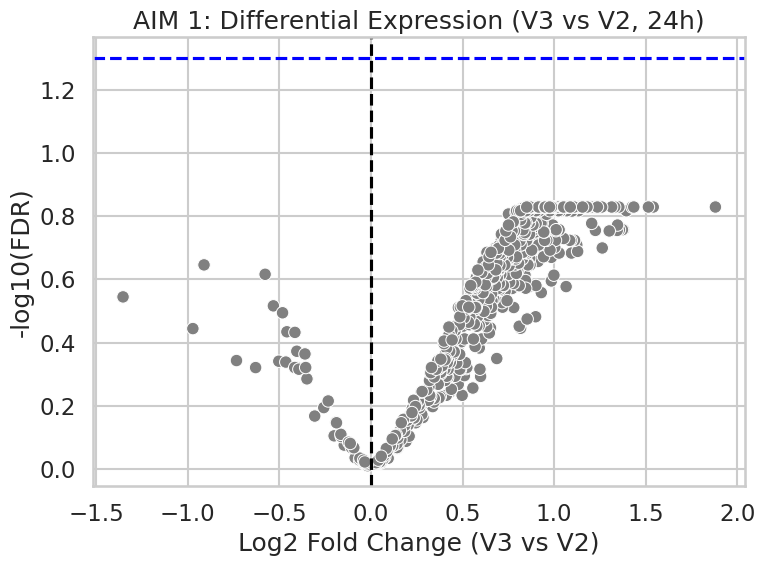

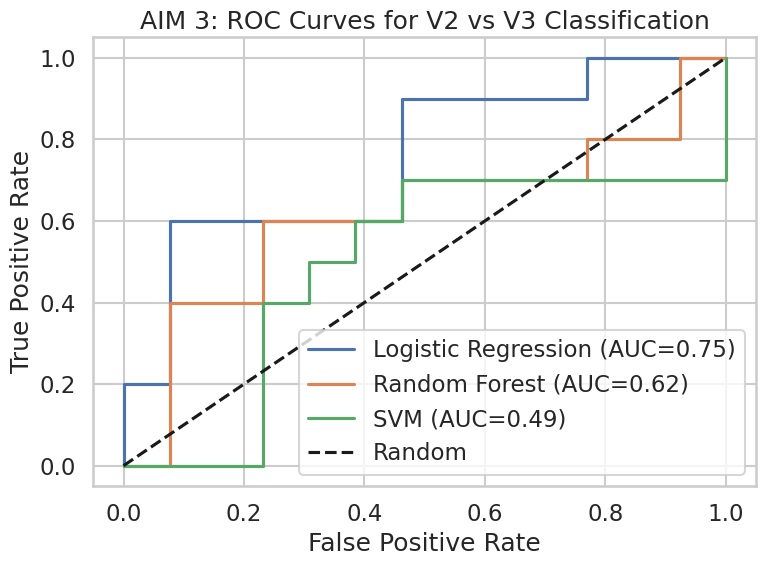

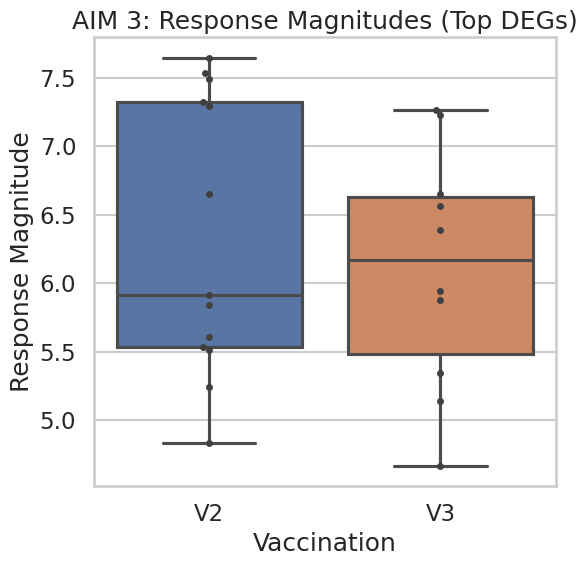

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", context="talk")

# Volcano Plot of Differential Expression for paired t-test
if 'results' in locals():
    results['-log10(p_adj)'] = -np.log10(results['p_adj'])
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='logFC_V3_vs_V2', y='-log10(p_adj)', data=results,
                    hue=results['p_adj']<0.05, palette={True:'red', False:'grey'}, legend=False)
    plt.axhline(-np.log10(0.05), linestyle='--', color='blue', label='FDR=0.05')
    plt.axvline(0, linestyle='--', color='black')
    plt.title("AIM 1: Differential Expression (V3 vs V2, 24h)")
    plt.xlabel("Log2 Fold Change (V3 vs V2)")
    plt.ylabel("-log10(FDR)")
    plt.tight_layout()
    plt.show()

# Classification ROC Curves
from sklearn.metrics import roc_curve, auc
models = {
    'Logistic Regression': (lr_proba, y_classification) if 'lr_proba' in locals() else None,
    'Random Forest': (rf_proba, y_classification) if 'rf_proba' in locals() else None,
    'SVM': (svm_proba, y_classification) if 'svm_proba' in locals() else None
}

plt.figure(figsize=(8,6))
for name, vals in models.items():
    if vals is not None:
        proba, y_true = vals
        fpr, tpr, _ = roc_curve(y_true, proba[:,1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--', label='Random')
plt.title("AIM 3: ROC Curves for V2 vs V3 Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Booster Response Boxplot
if 'response_df' in locals():
    plt.figure(figsize=(6,6))
    sns.boxplot(x='Vaccination', y='Magnitude', data=response_df)
    sns.swarmplot(x='Vaccination', y='Magnitude', data=response_df, color=".25")
    plt.title("AIM 3: Response Magnitudes (Top DEGs)")
    plt.ylabel("Response Magnitude")
    plt.tight_layout()
    plt.show()